# LSTM PER ITEM


In [3]:
from darts.dataprocessing.transformers import Scaler
import numpy as np
import pickle
import warnings
import logging
from tqdm import tqdm 
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

In [4]:
with open("/path/to/pklFiles/low_series_dict_small.pkl","rb") as file:
        
    target_series_dict=pickle.load(file)


In [5]:
train_target_dict = {}
test_target_dict = {}
future_covariates_dict = {}
all_ids = []
item_scalers = {}



for i_id in  (target_series_dict.keys()):
    full_target_series, covariates = target_series_dict[i_id]

    target_for_scaler, train_target, test_target = full_target_series[:-64], full_target_series[:-28], full_target_series[-28:]

    all_ids.append(i_id)
    train_target = train_target.astype(np.float32)
    test_target = test_target.astype(np.float32)
    target_for_scaler = target_for_scaler.astype(np.float32)

    scaler_target = Scaler()
    scaler_covs = Scaler()
    item_scalers[i_id] = {
        'target': scaler_target,
        'covariates': scaler_covs,
    }

    item_scalers[i_id]['target'].fit(target_for_scaler)
    train_target_scaled = item_scalers[i_id]['target'].transform(train_target)
    #test_target_scaled = item_scalers[i_id]['target'].transform(test_target)
    covariates_scaled = item_scalers[i_id]['covariates'].fit_transform(covariates)

    train_target_dict[i_id] = train_target_scaled.astype(np.float32)
    test_target_dict[i_id] = test_target.astype(np.float32)
    future_covariates_dict[i_id] = covariates_scaled.astype(np.float32)

In [6]:
del target_series_dict

In [7]:
print(f"Number of series: {len(all_ids)}")
print(f"Example training series length: {train_target_dict[i_id].n_timesteps}")
print(f"Example validation series length: {test_target_dict[i_id].n_timesteps}")
print(f"Example covariates series length: {future_covariates_dict[i_id].n_timesteps}")

Number of series: 30490
Example training series length: 1941
Example validation series length: 28
Example covariates series length: 1969


In [ ]:
print(future_covariates_dict[i_id].end_time())
print(train_target_dict[i_id].end_time())
print(test_target_dict[i_id].end_time())


2016-06-19 00:00:00
2016-05-22 00:00:00
2016-06-19 00:00:00


In [8]:
from darts.models import RNNModel

# Load the best checkpoint model
loaded_model = RNNModel.load_from_checkpoint(model_name="global_low_small", best=True)


In [9]:
# forecast_item = {}
# for i_id in tqdm(train_target_dict.keys(), total=len(train_target_dict.keys()), desc="Forecasting series"):
#     forecast_item[i_id] = loaded_model.predict(n=28,
#                                                series = train_target_dict[i_id],
#                                                future_covariates = future_covariates_dict[i_id],
#                                                verbose=False
#     )


# Convert dictionary values to lists
series_list = list(train_target_dict.values())  
future_covariates_list = list(future_covariates_dict.values())  

# Run prediction in one step (assuming the model supports batch prediction)
forecast_item = loaded_model.predict(
    n=28,
    series=series_list,
    future_covariates=future_covariates_list,
    verbose=False
)


# Evaluation

In [10]:
import pandas as pd 
weights_df = pd.read_csv("/path/to/ExtraFiles/weights_validation.csv")

# We only want rows for Level12
weights_df = weights_df[weights_df["Level_id"] == "Level12"].copy()

# Create a new 'id' column by combining Agg_Level_1 and Agg_Level_2
weights_df["id"] =weights_df["Agg_Level_2"] + "_" + weights_df["Agg_Level_1"] 


weights_df = weights_df.sort_values(['id'])
# Build a dictionary: {id_string: weight_value}
weights_map = dict(zip(weights_df["id"], weights_df["weight"]))

In [11]:
from darts.metrics import rmse,mae,rmsse

In [12]:
transformed_forecast_item = {}
transformed_train_target_dict = {}
index = 0
for i_id in all_ids:
    transformed_forecast_item[index] = item_scalers[i_id]['target'].inverse_transform(forecast_item[index])
    transformed_train_target_dict[i_id] = item_scalers[i_id]['target'].inverse_transform(train_target_dict[i_id])
    index+=1

In [13]:

wrmsse_list = []
index = 0
for i_id in all_ids:
    weight_value = weights_map[i_id]
    wrmsse_value = weight_value*rmsse(actual_series=test_target_dict[i_id],pred_series=transformed_forecast_item[index], insample=transformed_train_target_dict[i_id])
    wrmsse_list.append(wrmsse_value)
    index+=1

In [14]:
print(f"WRMSSE = {sum(wrmsse_list)}")

WRMSSE = 0.8847968629224077


In [15]:
rmse_dict = {}
mae_dict = {}
index = 0
for i_id in all_ids:
    forecast = transformed_forecast_item[index]
    val_series = test_target_dict[i_id]

    error_rmse = rmse(val_series, forecast)
    error_mae = mae(val_series,forecast)
    rmse_dict[i_id] = error_rmse
    mae_dict[i_id] = error_mae
    index += 1


# Print the mean RMSE
print(f"\nMean RMSE across all series: {sum(rmse_dict.values()) / len(rmse_dict):.3f}")
print(f"\nMean MAE across all series: {sum(mae_dict.values()) / len(mae_dict):.3f}")


Mean RMSE across all series: 1.436

Mean MAE across all series: 1.141


In [16]:
metrics_df = pd.DataFrame({
    'id': all_ids,
    'RMSE': list(rmse_dict.values()),
    'MAE' : list(mae_dict.values())
})


In [17]:
output_path = '/path/to/RMSE_MAE/metrics_df_LSTM.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(metrics_df, f)

In [14]:
print(f"Number of RMSE's above 10 -> {(metrics_df['RMSE'] > 10).sum()}")
# Determine the number of top 10% elements
top_10_percent_count = int(len(metrics_df) * 0.10)

# Sort RMSE values in descending order and take the top 10%
top_10_percent_rmse_sum = metrics_df['RMSE'].nlargest(top_10_percent_count).sum()

print(top_10_percent_rmse_sum)


Number of RMSE's above 10 -> 267
16497.727


In [16]:
# Calculate additional statistics
mean_rmse = metrics_df['RMSE'].mean()
median_rmse = metrics_df['RMSE'].median()
std_rmse = metrics_df['RMSE'].std()
min_rmse = metrics_df['RMSE'].min()
max_rmse = metrics_df['RMSE'].max()

# Print the statistics
print("\nRMSE Statistics:")
print(f"Mean RMSE: {mean_rmse:.2f}")
print(f"Median RMSE: {median_rmse:.2f}")
print(f"Standard Deviation of RMSE: {std_rmse:.2f}")
print(f"Minimum RMSE: {min_rmse:.2f}")
print(f"Maximum RMSE: {max_rmse:.2f}")



RMSE Statistics:
Mean RMSE: 1.44
Median RMSE: 0.94
Standard Deviation of RMSE: 1.90
Minimum RMSE: 0.17
Maximum RMSE: 45.99


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

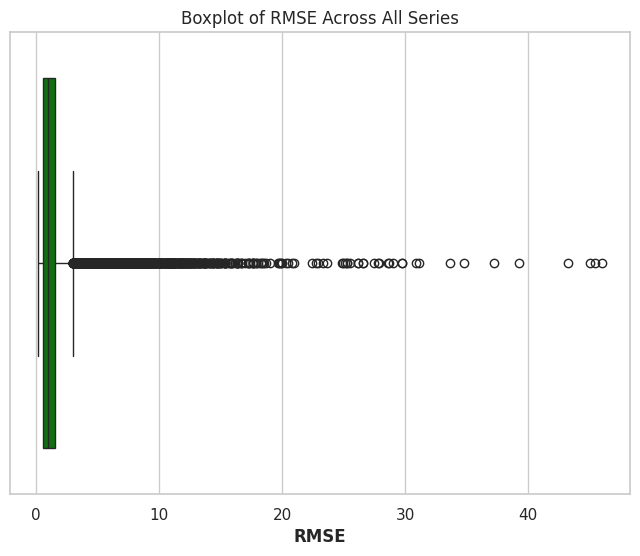

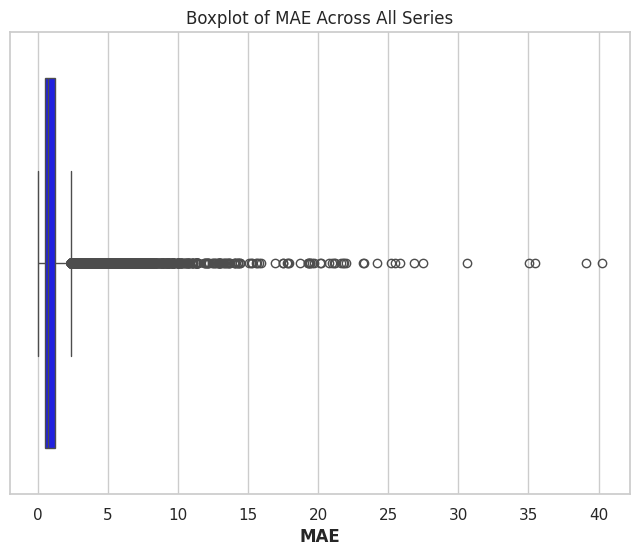

In [29]:
# Plot a boxplot of RMSE values
plt.figure(figsize=(8, 6))
sns.boxplot(x=metrics_df['RMSE'], color='green')
plt.title('Boxplot of RMSE Across All Series')
plt.xlabel('RMSE')
plt.show()

# Plot a boxplot of RMSE values
plt.figure(figsize=(8, 6))
sns.boxplot(x=metrics_df['MAE'], color='blue')
plt.title('Boxplot of MAE Across All Series')
plt.xlabel('MAE')
plt.show()


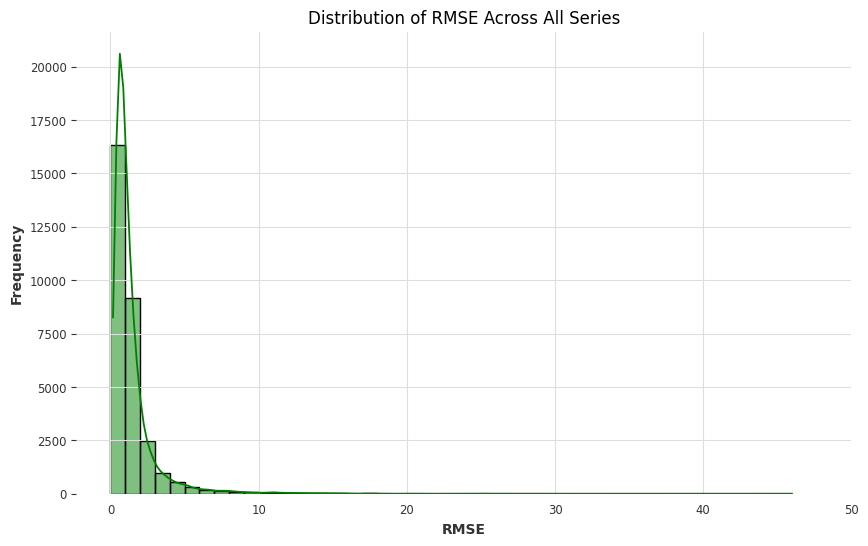

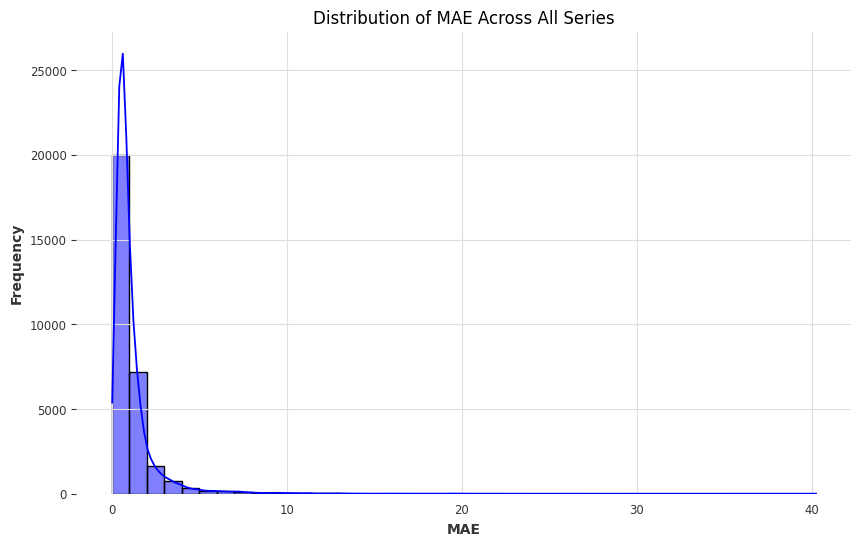

In [18]:
# Define bin width and range for x-axis ticks
bin_width = 1  # Each bar represents a width of 1
x_min = int(metrics_df['RMSE'].min())  # Round to the nearest integer
x_max = int(metrics_df['RMSE'].max())  # Round to the nearest integer
bins = np.arange(x_min, x_max + bin_width, bin_width)  # Ensure each bin is of width 1
  # Set x-axis ticks with increments of 10
x_ticks = np.arange(0, x_max + 10, 10)
# Plot a histogram of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['RMSE'], bins=bins, kde=True, color='green')

# Set title and labels
plt.title('Distribution of RMSE Across All Series')
plt.xlabel('RMSE')
plt.ylabel('Frequency')

# Set x-axis tick increments
plt.xticks(x_ticks)

plt.show()



# Define bin width and range for x-axis ticks
bin_width = 1  # Each bar represents a width of 1
x_min = int(metrics_df['MAE'].min())  # Round to the nearest integer
x_max = int(metrics_df['MAE'].max())  # Round to the nearest integer
bins = np.arange(x_min, x_max + bin_width, bin_width)  # Ensure each bin is of width 1
  # Set x-axis ticks with increments of 10
x_ticks = np.arange(0, x_max + 10, 10)
# Plot a histogram of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(metrics_df['MAE'], bins=bins, kde=True, color='blue')

# Set title and labels
plt.title('Distribution of MAE Across All Series')
plt.xlabel('MAE')
plt.ylabel('Frequency')

# Set x-axis tick increments
plt.xticks(x_ticks)

plt.show()